In [1]:
import numpy as np
from biophi.humanization.methods.sapiens.predict import sapiens_predict_seq, sapiens_predict_chain
import pandas as pd
import numpy as np
import torch
from abnumber import Chain

In [2]:
def get_embeds(chain):
    pred, extra = sapiens_predict_seq(
        seq=chain.seq[:142],
        chain_type=chain.chain_type,
        return_all_hiddens=True
    )
    return extra

In [3]:
def embed_seq(seq, layer=4):
    #if len(seq) > 142:
    #    seq = seq[:142]
    if seq == "QVQLQESGPRLVKPSDTLSLTCTVSGGSITSDSHYWGWVRQSPGKGLEWIASTSDSGSTYHNRPIYYNPSLKSRVTISVATSKNQFSLKLRSVTAADTAMYYCVRQWRYSSGSLDCWGQGILVTVSS" or seq == "EPQLQESGPTLVEASETLSLTCAVSGDSTAACNSFWGWVRQPPGKGLEWVGSLSHCASYWNRGWTYHNPSLKSRLTLALDTPKNLVFLKLNSVTAADTATYYCARFGGEVLRYTDWPKPAWVDLWGRGTLVTVSS":
        pred, extra = sapiens_predict_seq(seq, chain_type="H", model_version='latest', return_all_hiddens=True)
    else:
        ch = Chain(seq, "imgt")
        extra = get_embeds(ch)
    layer_state = extra['inner_states'][layer]
    #layer_reduced = torch.mean(fourth, (0, 1))
    
    return layer_state

In [4]:
chen_data = pd.read_csv("../diplomka/di-pred/data/chen/deduplicated/chen_data.csv", index_col=0)
chen_data.head()

,Antibody_ID,heavy,light,Y
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0


In [5]:
aa_embeddings = {}

In [7]:
for seq in chen_data["heavy"]:
    embeds = embed_seq(seq, 4).numpy()
    for i, aa in enumerate(seq):
        if i > 142:
            break
        this_aa = aa_embeddings.get(aa, [])
        try:
            this_aa.append(embeds[i+1][0])
            aa_embeddings[aa] = this_aa
        except IndexError as e:
            print(seq)
            print(e)
            break

EVQVVESGGGVVQPGRSLRLSCTASGFTFSNFAMGWVRQAPGKGLEWVAFISSDGSNKNYGDSVKGRFTISRDNSKNTVFLQMNSLRVEDTALYYCAKDVGDYKSDEWGT
index 108 is out of bounds for axis 0 with size 108


In [8]:
len(aa_embeddings["G"])

20891

In [9]:
avg_embeddings = {}
for aa, embeds in aa_embeddings.items():
    avg_embeddings[aa] = np.mean(embeds, axis=0)

In [10]:
avg_embeddings["G"]

array([ 0.5982515 ,  0.13410734,  0.20607784,  0.4386581 ,  0.37758714,
        0.20928387, -0.15174393, -0.54333556, -0.6192946 ,  0.08610747,
       -0.04562759, -0.09132405, -0.10046086,  0.61160475, -0.482084  ,
        0.12285791,  0.45776454, -0.10156195,  0.13402376,  0.37640473,
        0.35484576,  0.02362585, -0.38811383,  0.04754244,  0.07318439,
       -0.60552835, -0.64319783, -0.08976725,  0.1171002 ,  0.34133175,
       -0.39372635, -0.00894412, -0.33694592,  0.5189189 ,  0.5620063 ,
       -0.22051965, -0.5528979 ,  0.12840842,  0.55966127,  0.10147157,
        1.1631454 ,  0.37170753,  0.36794403, -0.36457238, -1.1049118 ,
        0.08824558, -0.2480651 , -0.3165683 ,  0.4758849 , -0.39972264,
       -0.04323062,  0.673232  , -0.3255388 ,  0.0035374 , -0.26010337,
        0.3236177 , -0.32332507, -0.01118304,  0.1962856 , -0.8515702 ,
        0.10369954, -0.85794926, -0.04025489, -0.13612527,  0.25469393,
        0.1841256 ,  0.08090537, -0.26788777,  0.40651327, -0.17

In [11]:
del(aa_embeddings)

In [12]:
for aa, embeds in avg_embeddings.items():
    np.savetxt(f"../diplomka/di-pred/data/aa_embeds/{aa}.txt", embeds)

In [1]:
import numpy as np 
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from os import path

In [2]:
DATA_DIR = "../../data"

In [4]:
avg_embeddings = {}
for aa in ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]:
    avg_embeddings[aa] = np.loadtxt(path.join(DATA_DIR, f"aa_embeds/{aa}.txt"))

In [8]:
all_aas = np.stack([value for aa, value in avg_embeddings.items()])
all_aas.shape

(20, 128)

In [15]:
avg_embeddings["E"][:4]

array([-0.06999911,  0.12572235,  0.50500107,  0.04555972])

In [16]:
df = pd.DataFrame(all_aas)
df.insert(0, "AA", ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"])

In [17]:
df.head()

,AA,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,A,-0.085962,-0.008316,0.178330,0.016752,0.073978,0.163546,-0.000088,-0.293104,0.048754,...,-0.476999,-0.512411,0.301371,0.159086,0.115479,-0.174416,-0.581010,-0.063700,-3.006306,0.020641
1,C,-0.080946,-0.151230,0.885428,-0.478934,-0.218426,0.297768,-0.194731,-0.851298,-0.300306,...,-0.423883,-0.412249,0.805094,-0.348605,0.186338,-0.647939,-0.898708,-0.561087,-3.038252,0.042514
2,D,-0.000720,-0.016567,0.155226,0.076530,0.157009,-0.083082,-0.138282,-0.295558,0.063856,...,-0.151437,0.019031,0.202792,0.005611,0.469985,-0.314752,-0.436408,-0.116348,-3.027245,-0.270519
3,E,-0.069999,0.125722,0.505001,0.045560,-0.074301,0.187816,-0.175275,-0.499588,0.074093,...,-0.287286,-0.231326,0.103002,0.278571,-0.061662,-0.189246,-0.467575,-0.277627,-2.987581,-0.110687
4,F,-0.161603,0.038484,0.229177,0.041155,0.297659,0.129874,0.022724,-0.444766,-0.240061,...,-0.055367,-0.100928,0.312706,-0.204234,0.227349,-0.397752,-0.335116,-0.010932,-3.014831,-0.096190


In [25]:
def plot_tsne(
    x, y, components, perplexity, n_iter, metric
):
    tsne = TSNE(n_components=components, verbose=1, perplexity=perplexity, n_iter=n_iter, metric=metric)
    X_embedded = tsne.fit_transform(x)
    
    df = pd.DataFrame()
    df['x'] = X_embedded[:,0]
    df['y'] = X_embedded[:,1]
    df["label"] = y

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        data=df,
        legend="full"
    )
    for i, txt in enumerate(y):
        plt.annotate(txt, (df["x"][i], df["y"][i]))
    plt.show()

/home/brazdilv/.conda/envs/tf-gpu/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/brazdilv/.conda/envs/tf-gpu/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.964611
[t-SNE] KL divergence after 300 iterations: 0.483512


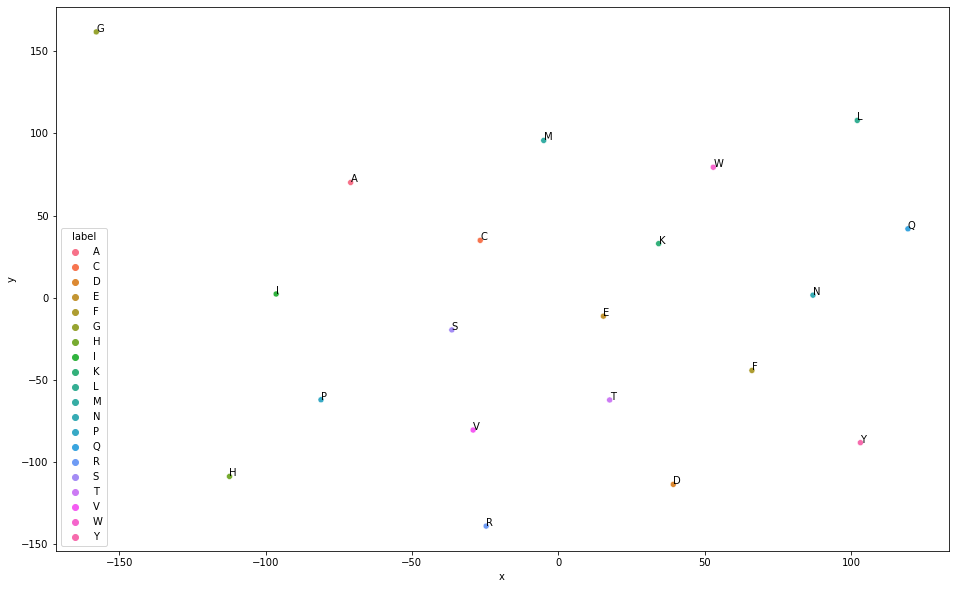

In [27]:
plot_tsne(df.drop("AA", axis=1), df["AA"], 2, perplexity=40, n_iter=300, metric="euclidean")

In [23]:
def plot_pca(
    x, y, components, comp_to_plot=[0,1]
):
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(x)
    
    df = pd.DataFrame()
    df['x'] = X_pca[:,comp_to_plot[0]]
    df['y'] = X_pca[:,comp_to_plot[1]]
    df["label"] = y
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        data=df,
        legend="full"
    )
    for i, txt in enumerate(y):
        plt.annotate(txt, (df["x"][i], df["y"][i]))
    plt.show()
    return X_pca

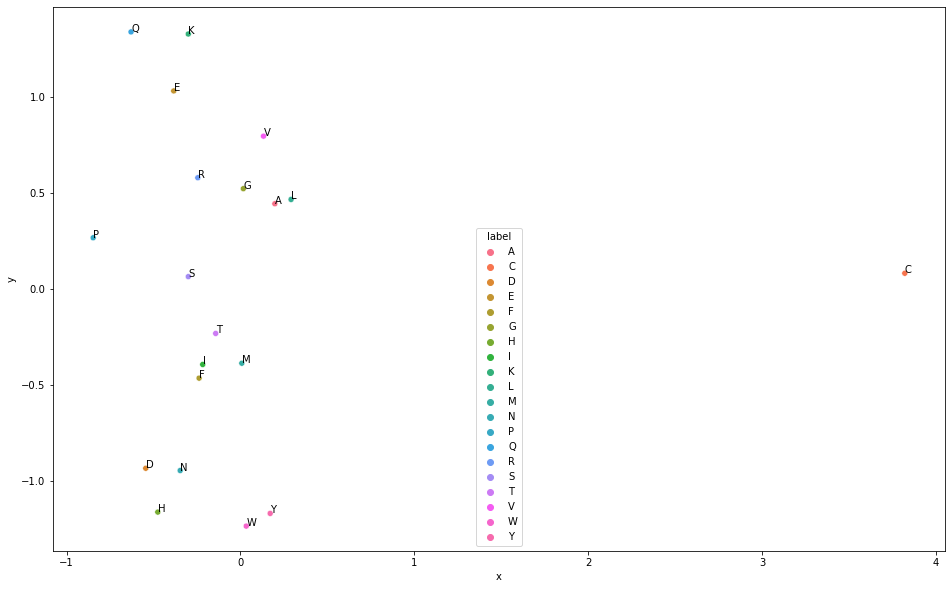

array([[ 0.19766122,  0.44305602],
       [ 3.820386  ,  0.08173168],
       [-0.54472711, -0.93149374],
       [-0.38384031,  1.02920088],
       [-0.23788499, -0.46322411],
       [ 0.01664441,  0.52136353],
       [-0.47545757, -1.15928307],
       [-0.21701792, -0.39225767],
       [-0.29989032,  1.32500688],
       [ 0.29094924,  0.46525518],
       [ 0.00774143, -0.3857101 ],
       [-0.34674312, -0.94331156],
       [-0.84711987,  0.26626525],
       [-0.62938803,  1.3358798 ],
       [-0.24532869,  0.57816503],
       [-0.29997733,  0.0643017 ],
       [-0.14240882, -0.23097855],
       [ 0.1324146 ,  0.7942596 ],
       [ 0.03318705, -1.23205037],
       [ 0.17080016, -1.16617637]])

In [24]:
plot_pca(df.drop("AA", axis=1), df["AA"], 2)

In [28]:
import umap

In [36]:
def plot_umap(x, y):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(x)
    
    df = pd.DataFrame()
    df['x'] = embedding[:, 0]
    df['y'] = embedding[:, 1]
    df["label"] = y
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        data=df,
        legend="full"
    )
    for i, txt in enumerate(y):
        plt.annotate(txt, (df["x"][i], df["y"][i]))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection Amino Acids', fontsize=20)
    plt.show()

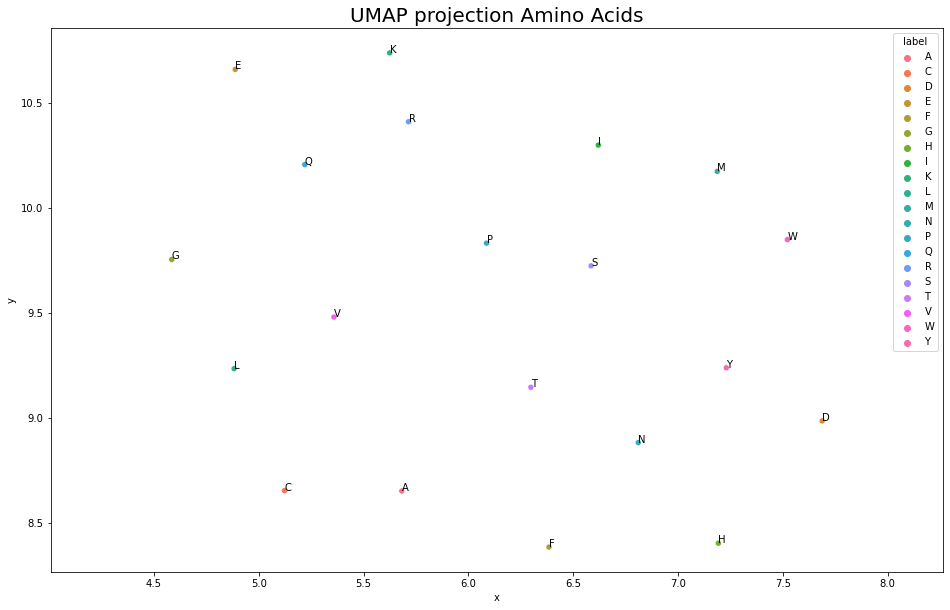

In [37]:
plot_umap(df.drop("AA", axis=1), df["AA"])